# Resources

In [1]:
# resources
import sys
sys.path.append("../py")
from direct.problems import planet2planet as p2pdir
from indirect.problems import planet2planet as p2pind
import pygmo as pg
import pygmo_plugins_nonfree as pg7
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
#%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Algorithm

In [2]:
# algorithm
uda = pg7.snopt7(True, "/usr/lib/libsnopt7_c.so")
uda.set_integer_option("Major iterations limit", 4000)
uda.set_integer_option("Iterations limit", 40000)
uda.set_numeric_option("Major optimality tolerance", 1e-2)
uda.set_numeric_option("Major feasibility tolerance", 1e-8)
algo = pg.algorithm(uda)
#uda = pg.mbh(algo, 1)
#algo = pg.algorithm(uda)

# Direct

In [ ]:
# direct problem
udpdir = p2pdir(
    p0="earth", pf="mars", mass=1000, tmax=0.3, isp=2500, nseg=50,
    t0lb=1000, t0ub=2000, Tlb=100, Tub=4000
)
probdir = pg.problem(udpdir)

In [ ]:
# population
popdir = pg.population(probdir, 1)

In [ ]:
# evolve
popdir = algo.evolve(popdir)

In [ ]:
# plot trajectory
udpdir.plot_traj(popdir.champion_x)

In [ ]:
# trajectory data
traj = udpdir.get_trajectory(popdir.champion_x)

In [ ]:
# plot control
plt.figure()
plt.plot(traj[:, 0], traj[:, 8], "k.-")
plt.ylabel("Throttle [ND]")
plt.xlabel("Time [days]")
plt.show()

# Indirect: Bounded Quadratic

In [ ]:
# Use previous solution
pert = 0.8
t0 = popdir.champion_x[0]
T = popdir.champion_x[1]
l = np.random.randn(7)
sol = np.hstack(([t0], [T], l))

In [ ]:
# bounded quadratic control problem
udpind = p2pind(
    p0="earth", pf="mars", mass=1000, tmax=0.05, isp=2500, atol=1e-10, rtol=1e-10,
    t0lb=t0-(t0*pert), t0ub=t0+(t0*pert), Tlb=T-(T*pert), Tub=T+(T*pert)
)
udpind.leg.dynamics.alpha = 0
udpind.leg.dynamics.bound = True
probind = pg.problem(udpind)

In [ ]:
# population
popind = pg.population(probind, 0)
popind.push_back(sol)

In [ ]:
# evolve
popind = algo.evolve(popind)

# Indirect: Mass Optimal

In [ ]:
np.save("../npy/indirect_planet2planet", sol)

In [3]:
sol = np.load("../npy/indirect_planet2planet.npy")

In [4]:
pert = 0.8
t0 = sol[0]
T = sol[1]

In [5]:
# create bounded control problem
udpind = p2pind(
    p0="earth", pf="mars", mass=1000, tmax=0.3, isp=2500, atol=1e-12, rtol=1e-12,
    t0lb=t0-(t0*pert), t0ub=t0+(t0*pert), Tlb=T-(T*pert), Tub=T+(T*pert)
)
udpind.leg.dynamics.alpha = 1
udpind.leg.dynamics.bound = True
probind = pg.problem(udpind)

In [6]:
# use previous solution
popind = pg.population(probind, 0)
popind.push_back(sol)

In [7]:
# evolve
popind = algo.evolve(popind)

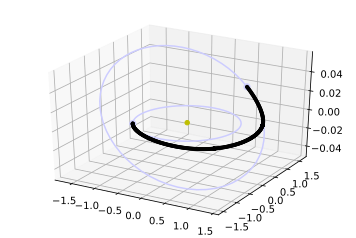

In [8]:
# plot trajectory
udpind.plot_traj(popind.champion_x)

In [9]:
# trajectory data
traj = udpind.leg.get_trajectory()

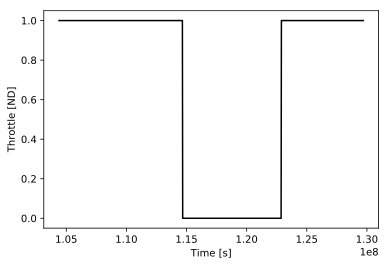

In [10]:
# plot throttle
plt.figure()
plt.plot(traj[:,0], traj[:,15], "k-")
plt.xlabel("Time [s]")
plt.ylabel("Throttle [ND]")
plt.show()

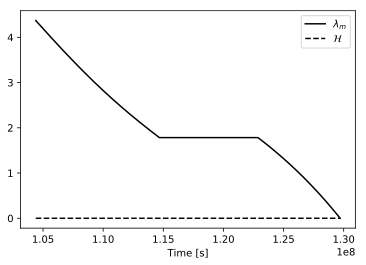

In [11]:
plt.figure()
plt.plot(traj[:,0], traj[:,14], "k-")
plt.plot(traj[:,0], traj[:,19], "k--")
plt.xlabel("Time [s]")
plt.legend(["$\lambda_m$", "$\mathcal{H}$"])
plt.show()

In [12]:
sol = popind.champion_x